In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import logging



## Logging

In [2]:
# Set up the basic configuration for logging
logging.basicConfig(
    level=logging.INFO,  # Set the threshold for the logger to the INFO level
    format='%(asctime)s - %(levelname)s - %(message)s'  # Define the format of the log messages
)
logger = logging.getLogger(__name__)  # Create a logger object with the name of the current module


### Load your datasets

In [3]:

logger.info("Loading train_data...")
train_data = pd.read_csv('C:\\Users\\King Betse\\Downloads\\rossmann-store-sales\\train.csv')
logger.info("Loaded train_data successfully.")
        
logger.info("Loading test_data...")
test_data = pd.read_csv('C:\\Users\\King Betse\\Downloads\\rossmann-store-sales\\test.csv')
logger.info("Loaded test_data successfully.")
        
logger.info("Loading sample_submission...")
sample_submission = pd.read_csv('C:\\Users\\King Betse\\Downloads\\rossmann-store-sales\\sample_submission.csv')
logger.info("Loaded sample_submission successfully.")
        
logger.info("Loading store...")
store = pd.read_csv('C:\\Users\\King Betse\\Downloads\\rossmann-store-sales\\store.csv')
logger.info("Loaded store successfully.")


2024-09-20 19:26:30,448 - INFO - Loading train_data...
C:\Users\King Betse\AppData\Local\Temp\ipykernel_28412\3981089011.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('C:\\Users\\King Betse\\Downloads\\rossmann-store-sales\\train.csv')
2024-09-20 19:26:31,047 - INFO - Loaded train_data successfully.
2024-09-20 19:26:31,048 - INFO - Loading test_data...
2024-09-20 19:26:31,084 - INFO - Loaded test_data successfully.
2024-09-20 19:26:31,085 - INFO - Loading sample_submission...
2024-09-20 19:26:31,096 - INFO - Loaded sample_submission successfully.
2024-09-20 19:26:31,097 - INFO - Loading store...
2024-09-20 19:26:31,102 - INFO - Loaded store successfully.


### Handle Missing Data


In [4]:
# Check for missing values and log the results
logger.info("Checking for missing values in train_data...")
missing_train = train_data.isnull().sum()
logger.info(f"Missing values in train_data:\n{missing_train}")

logger.info("Checking for missing values in test_data...")
missing_test = test_data.isnull().sum()
logger.info(f"Missing values in test_data:\n{missing_test}")

logger.info("Checking for missing values in sample_submission...")
missing_submission = sample_submission.isnull().sum()
logger.info(f"Missing values in sample_submission:\n{missing_submission}")

logger.info("Checking for missing values in store...")
missing_store = store.isnull().sum()
logger.info(f"Missing values in store:\n{missing_store}")

# Drop rows with critical missing values in train_data
logger.info("Dropping rows with missing Sales data from train_data...")
train_data.dropna(subset=['Sales'], inplace=True)  # Ensure no missing sales data
logger.info("Dropped rows with missing Sales data successfully.")

2024-09-20 19:26:31,116 - INFO - Checking for missing values in train_data...
2024-09-20 19:26:31,249 - INFO - Missing values in train_data:
Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64
2024-09-20 19:26:31,250 - INFO - Checking for missing values in test_data...
2024-09-20 19:26:31,257 - INFO - Missing values in test_data:
Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64
2024-09-20 19:26:31,258 - INFO - Checking for missing values in sample_submission...
2024-09-20 19:26:31,260 - INFO - Missing values in sample_submission:
Id       0
Sales    0
dtype: int64
2024-09-20 19:26:31,261 - INFO - Checking for missing values in store...
2024-09-20 19:26:31,263 - INFO - Missing values in store:
Store                          0
StoreType

### Detect and Handle Outliers

In [5]:
# Function to detect outliers using Z-scores
def detect_outliers_zscore(data, threshold=3):
    logger.info("Detecting outliers using Z-score method...")
    mean = np.mean(data)
    std_dev = np.std(data)
    z_scores = [(y - mean) / std_dev for y in data]
    outliers = np.where(np.abs(z_scores) > threshold)
    logger.info(f"Number of outliers detected using Z-score: {len(outliers[0])}")
    return outliers

# Detect outliers in 'Sales'
logger.info("Detecting outliers in 'Sales' using Z-scores...")
outlier_indices = detect_outliers_zscore(train_data['Sales'])
train_data = train_data.drop(outlier_indices[0])  # Remove outliers
logger.info("Outliers removed from 'Sales' using Z-scores.")

# Alternatively, using IQR
logger.info("Detecting outliers using IQR method...")
Q1 = train_data['Sales'].quantile(0.25)
Q3 = train_data['Sales'].quantile(0.75)
IQR = Q3 - Q1

# Remove outliers
initial_count = len(train_data)
train_data = train_data[~((train_data['Sales'] < (Q1 - 1.5 * IQR)) | (train_data['Sales'] > (Q3 + 1.5 * IQR)))]
final_count = len(train_data)

logger.info(f"Initial number of rows: {initial_count}, Final number of rows after IQR outlier removal: {final_count}")
logger.info("Outliers removed from 'Sales' using IQR method.")

2024-09-20 19:26:31,307 - INFO - Detecting outliers in 'Sales' using Z-scores...
2024-09-20 19:26:31,308 - INFO - Detecting outliers using Z-score method...
2024-09-20 19:26:31,635 - INFO - Number of outliers detected using Z-score: 9731
2024-09-20 19:26:31,703 - INFO - Outliers removed from 'Sales' using Z-scores.
2024-09-20 19:26:31,704 - INFO - Detecting outliers using IQR method...
2024-09-20 19:26:31,781 - INFO - Initial number of rows: 1007478, Final number of rows after IQR outlier removal: 989166
2024-09-20 19:26:31,783 - INFO - Outliers removed from 'Sales' using IQR method.


### Merge with Store Data

In [6]:
# Merging train_data with test_data
logger.info("Merging train_data with test_data...")
merged_train_and_test = pd.merge(train_data, test_data, on='Store', how='left')
logger.info("Merged train_data and test_data successfully.")
logger.info(f"Merged train_and_test columns: {merged_train_and_test.columns.tolist()}")

# Merging train_data with store
logger.info("Merging train_data with store...")
merged_data = pd.merge(merged_train_and_test, store, on='Store', how='left')
logger.info("Merged train_data and store successfully.")
logger.info(f"Merged_data columns: {merged_data.columns.tolist()}")

# Merging test_data with store
logger.info("Merging test_data with store...")
merged_test = pd.merge(test_data, store, on='Store', how='left')
logger.info("Merged test_data and store successfully.")
logger.info(f"Merged_test columns: {merged_test.columns.tolist()}")

# Merging train_data with store again (if needed)
logger.info("Merging train_data with store again...")
merged_train = pd.merge(train_data, store, on='Store', how='left')
logger.info("Merged train_data and store successfully.")
logger.info(f"Merged_train columns: {merged_train.columns.tolist()}")

2024-09-20 19:26:31,797 - INFO - Merging train_data with test_data...
2024-09-20 19:26:42,650 - INFO - Merged train_data and test_data successfully.
2024-09-20 19:26:42,679 - INFO - Merged train_and_test columns: ['Store', 'DayOfWeek_x', 'Date_x', 'Sales', 'Customers', 'Open_x', 'Promo_x', 'StateHoliday_x', 'SchoolHoliday_x', 'Id', 'DayOfWeek_y', 'Date_y', 'Open_y', 'Promo_y', 'StateHoliday_y', 'SchoolHoliday_y']
2024-09-20 19:26:42,683 - INFO - Merging train_data with store...
2024-09-20 19:27:28,707 - INFO - Merged train_data and store successfully.
2024-09-20 19:27:28,729 - INFO - Merged_data columns: ['Store', 'DayOfWeek_x', 'Date_x', 'Sales', 'Customers', 'Open_x', 'Promo_x', 'StateHoliday_x', 'SchoolHoliday_x', 'Id', 'DayOfWeek_y', 'Date_y', 'Open_y', 'Promo_y', 'StateHoliday_y', 'SchoolHoliday_y', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
2024-09-20 1

### Count promo distribution

In [7]:
# Calculate promo distribution in training set
logger.info("Calculating Promo distribution in the training set...")
promo_train_counts = train_data['Promo'].value_counts()
logger.info(f"Promo Distribution in Training Set:\n{promo_train_counts}")

# Calculate promo distribution in test set
logger.info("Calculating Promo distribution in the test set...")
promo_test_counts = test_data['Promo'].value_counts()
logger.info(f"Promo Distribution in Test Set:\n{promo_test_counts}")# Calculate promo distribution in training set
logger.info("Calculating Promo distribution in the training set...")
promo_train_counts = train_data['Promo'].value_counts()
logger.info(f"Promo Distribution in Training Set:\n{promo_train_counts}")

# Calculate promo distribution in test set
logger.info("Calculating Promo distribution in the test set...")
promo_test_counts = test_data['Promo'].value_counts()
logger.info(f"Promo Distribution in Test Set:\n{promo_test_counts}")



2024-09-20 19:27:29,584 - INFO - Calculating Promo distribution in the training set...
2024-09-20 19:27:29,655 - INFO - Promo Distribution in Training Set:
Promo
0    621298
1    367868
Name: count, dtype: int64
2024-09-20 19:27:29,660 - INFO - Calculating Promo distribution in the test set...
2024-09-20 19:27:29,665 - INFO - Promo Distribution in Test Set:
Promo
0    24824
1    16264
Name: count, dtype: int64
2024-09-20 19:27:29,668 - INFO - Calculating Promo distribution in the training set...
2024-09-20 19:27:29,690 - INFO - Promo Distribution in Training Set:
Promo
0    621298
1    367868
Name: count, dtype: int64
2024-09-20 19:27:29,692 - INFO - Calculating Promo distribution in the test set...
2024-09-20 19:27:29,698 - INFO - Promo Distribution in Test Set:
Promo
0    24824
1    16264
Name: count, dtype: int64


### Visualize Distributions

2024-09-20 19:27:29,737 - INFO - Starting to plot Promo distribution...


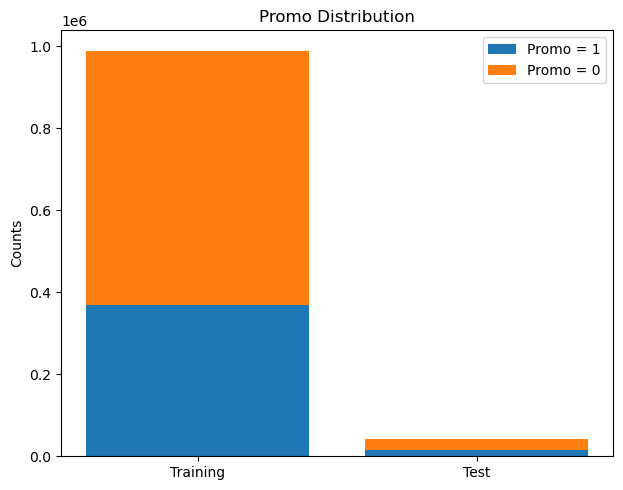

2024-09-20 19:27:30,748 - INFO - Promo distribution plot displayed successfully.


In [8]:
# Plotting Promo Distribution
logger.info("Starting to plot Promo distribution...")
plt.figure(figsize=(12, 5))

# Promo
plt.subplot(1, 2, 1)
plt.bar(['Training', 'Test'], [promo_train_counts[1], promo_test_counts[1]], label='Promo = 1')
plt.bar(['Training', 'Test'], [promo_train_counts[0], promo_test_counts[0]], 
         bottom=[promo_train_counts[1], promo_test_counts[1]], label="Promo = 0")
plt.title('Promo Distribution')
plt.ylabel('Counts')
plt.legend()

plt.tight_layout()
plt.show()
logger.info("Promo distribution plot displayed successfully.")

### Statical Comparison

In [9]:
# Create contingency table for Promo
promo_table = [[promo_train_counts[0], promo_train_counts[1]],
               [promo_test_counts[0], promo_test_counts[1]]]

logger.info("Contingency table for Promo created:")
logger.info(f"{promo_table}")

# Perform Chi-Squared test
chi2, p, _, _ = chi2_contingency(promo_table)
logger.info(f"Chi-Squared Test for Promo: chi2 = {chi2}, p-value = {p}")

# Print results
print(f"Chi-Squared Test for Promo: chi2 = {chi2}, p-value = {p}")

2024-09-20 19:27:30,778 - INFO - Contingency table for Promo created:
2024-09-20 19:27:30,781 - INFO - [[621298, 367868], [24824, 16264]]


NameError: name 'chi2_contingency' is not defined

## Check & compare sales behavior before, during, and after holidays

In [52]:
# Convert 'Date' column to datetime
logger.info("Converting 'Date' column to datetime format...")
train_data['Date'] = pd.to_datetime(train_data['Date'])
logger.info("'Date' column converted successfully.")


2024-09-20 19:12:56,736 - INFO - Converting 'Date' column to datetime format...
2024-09-20 19:12:56,866 - INFO - 'Date' column converted successfully.


### Define Holiday Periods

In [53]:
# Define function to determine holiday period
def holiday_period(row):
    if row['StateHoliday'] != '0':
        return 'During Holiday'
    elif (row['Date'].isocalendar()[2] in [5, 6, 7, 8, 9] and row['StateHoliday'] == '0') or \
         ((row['Date'] - pd.DateOffset(days=1)).isocalendar()[2] in [5, 6, 7, 8, 9]):
        return 'Before Holiday'
    else:
        return 'After Holiday'

# Log the start of the holiday period calculation
logger.info("Calculating Holiday_Period for each row in train_data...")

# Apply the holiday_period function to create the Holiday_Period column
train_data['Holiday_Period'] = train_data.apply(holiday_period, axis=1)

# Log the completion of the calculation
logger.info("Holiday_Period calculation completed.")

# Display the first few rows of the updated DataFrame
logger.info("Displaying the first few rows of train_data with Holiday_Period:")
logger.info(f"\n{train_data.head()}")

2024-09-20 19:13:20,119 - INFO - Calculating Holiday_Period for each row in train_data...
2024-09-20 19:14:12,082 - INFO - Holiday_Period calculation completed.
2024-09-20 19:14:12,083 - INFO - Displaying the first few rows of train_data with Holiday_Period:
2024-09-20 19:14:12,101 - INFO - 
   Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   
5      6          5 2015-07-31   5651        589     1      1            0   

   SchoolHoliday  Holiday_Period  
0              1  Before Holiday  
1              1  Before Holiday  
2              1  Before Holiday  
4              1  Before Holiday  
5              1  Before Holiday  


###  Aggregate Sales Data for Holiday Period

In [54]:
# Group by 'Holiday_Period' and calculate sales metrics
logger.info("Calculating sales comparison by Holiday_Period...")
sale_comparison = train_data.groupby('Holiday_Period')['Sales'].agg(['mean', 'sum', 'count']).reset_index()

# Log the results of the sales comparison
logger.info("Sales comparison calculated successfully.")
logger.info(f"\n{sale_comparison}")

# Display sale_comparison DataFrame
sale_comparison

2024-09-20 19:14:12,121 - INFO - Calculating sales comparison by Holiday_Period...


2024-09-20 19:14:12,284 - INFO - Sales comparison calculated successfully.
2024-09-20 19:14:12,287 - INFO - 
   Holiday_Period         mean         sum   count
0   After Holiday  6601.377684  2341185197  354651
1  Before Holiday  4935.075488  2346588914  475492
2  During Holiday  4446.421530   707083291  159023


,Holiday_Period,mean,sum,count
0,After Holiday,6601.377684,2341185197,354651
1,Before Holiday,4935.075488,2346588914,475492
2,During Holiday,4446.421530,707083291,159023


### Visualization of Average Sales Before, During, and After Holidays

2024-09-20 19:14:26,206 - INFO - Starting to plot average sales by Holiday_Period...


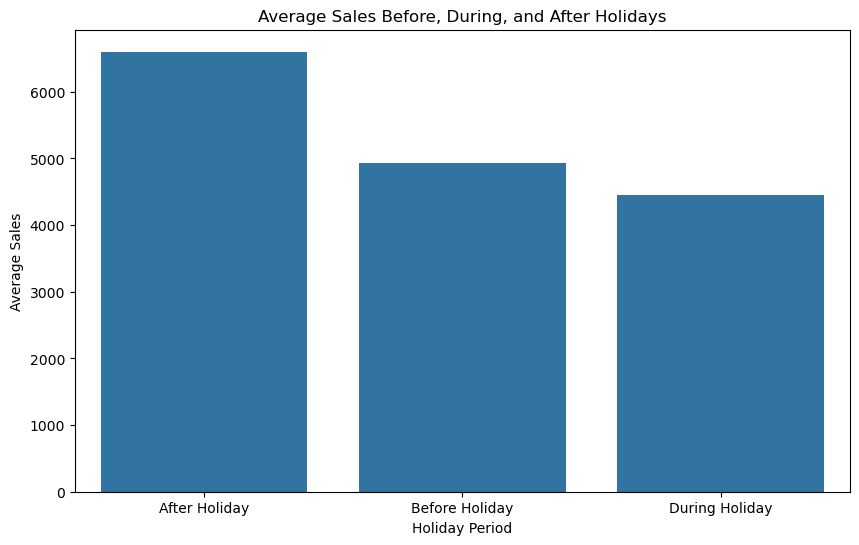

2024-09-20 19:14:26,403 - INFO - Average sales plot displayed successfully.


In [55]:
# Plotting average sales by Holiday_Period
logger.info("Starting to plot average sales by Holiday_Period...")
plt.figure(figsize=(10, 6))
sns.barplot(x='Holiday_Period', y='mean', data=sale_comparison)
plt.title('Average Sales Before, During, and After Holidays')
plt.xlabel('Holiday Period')
plt.ylabel('Average Sales')
plt.show()
logger.info("Average sales plot displayed successfully.")

### Extract Features

In [56]:
# Log the start of month and day extraction
logger.info("Extracting Month and Day from 'Date' column...")

# Extract Month and Day
train_data['Month'] = train_data['Date'].dt.month
train_data['Day'] = train_data['Date'].dt.day

# Log the completion of extraction
logger.info("Month and Day extraction completed successfully.")
logger.info(f"First few rows of train_data after extraction:\n{train_data[['Date', 'Month', 'Day']].head()}")

2024-09-20 19:14:53,162 - INFO - Extracting Month and Day from 'Date' column...
2024-09-20 19:14:53,237 - INFO - Month and Day extraction completed successfully.
2024-09-20 19:14:53,250 - INFO - First few rows of train_data after extraction:
        Date  Month  Day
0 2015-07-31      7   31
1 2015-07-31      7   31
2 2015-07-31      7   31
4 2015-07-31      7   31
5 2015-07-31      7   31


### Create Holiday Indicators

In [57]:
# Define function to determine holiday indicator
def holiday_indicator(row):
    if row['Month'] == 12 and row['Day'] == 25:
        return 'Christmas'
    elif row['Month'] == 1 and row['Day'] == 1:
        return 'New Year'
    elif row['Month'] == 4 and (row['Day'] >= 1 and row['Day'] <= 30):  # Example for Easter
        return 'Easter'
    elif (row['Month'] == 4 and row['Day'] == 21) or (row['Month'] == 5 and row['Day'] == 1):  # Eid al-Fitr example
        return 'Eid al-Fitr'
    elif (row['Month'] == 6 and row['Day'] == 28) or (row['Month'] == 7 and row['Day'] == 6):  # Eid al-Adha example
        return 'Eid al-Adha'
    else:
        return 'Regular Day'

# Log the start of applying the holiday indicator function
logger.info("Applying holiday_indicator function to create 'Season' column...")

# Apply the function to create the 'Season' column
train_data['Season'] = train_data.apply(holiday_indicator, axis=1)

# Log the completion of the process
logger.info("Season column created successfully.")
logger.info(f"First few rows of train_data with 'Season' column:\n{train_data[['Date', 'Month', 'Day', 'Season']].head()}")

2024-09-20 19:15:23,060 - INFO - Applying holiday_indicator function to create 'Season' column...
2024-09-20 19:15:46,994 - INFO - Season column created successfully.
2024-09-20 19:15:47,024 - INFO - First few rows of train_data with 'Season' column:
        Date  Month  Day       Season
0 2015-07-31      7   31  Regular Day
1 2015-07-31      7   31  Regular Day
2 2015-07-31      7   31  Regular Day
4 2015-07-31      7   31  Regular Day
5 2015-07-31      7   31  Regular Day


### Aggregate Sales Data

In [58]:
# Calculate seasonal sales based on the 'Season' column
logger.info("Calculating seasonal sales based on the 'Season' column...")
seasonal_sales_holiday_days = train_data.groupby("Season")["Sales"].agg(["mean", "sum", "count"]).reset_index()

# Log the results of the seasonal sales calculation
logger.info("Seasonal sales calculation completed successfully.")
logger.info(f"\n{seasonal_sales_holiday_days}")

# Display the seasonal_sales_holiday_days DataFrame
seasonal_sales_holiday_days

2024-09-20 19:15:47,040 - INFO - Calculating seasonal sales based on the 'Season' column...


2024-09-20 19:15:47,168 - INFO - Seasonal sales calculation completed successfully.
2024-09-20 19:15:47,171 - INFO - 
        Season         mean         sum   count
0    Christmas   113.729360      232804    2047
1       Easter  5416.588073   528447749   97561
2  Eid al-Adha  4166.988958    26793739    6430
3  Eid al-Fitr   104.558594      347971    3328
4     New Year    86.207722      288020    3341
5  Regular Day  5520.791182  4838747119  876459


,Season,mean,sum,count
0,Christmas,113.729360,232804,2047
1,Easter,5416.588073,528447749,97561
2,Eid al-Adha,4166.988958,26793739,6430
3,Eid al-Fitr,104.558594,347971,3328
4,New Year,86.207722,288020,3341
5,Regular Day,5520.791182,4838747119,876459


### Visualization 

2024-09-20 19:16:15,817 - INFO - Starting to plot average sales during seasonal events...


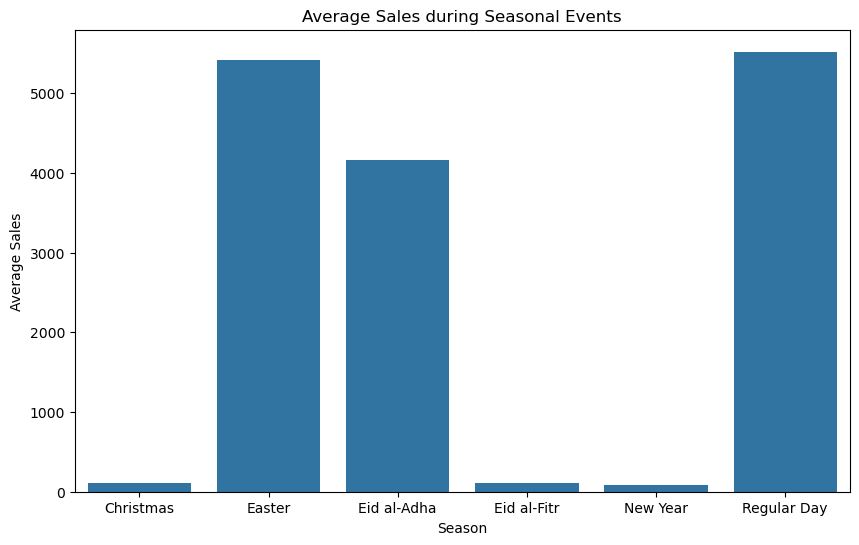

2024-09-20 19:16:16,005 - INFO - Average sales plot for seasonal events displayed successfully.


In [59]:
# Plotting average sales during seasonal events
logger.info("Starting to plot average sales during seasonal events...")
plt.figure(figsize=(10, 6))
sns.barplot(x='Season', y='mean', data=seasonal_sales_holiday_days)
plt.title('Average Sales during Seasonal Events')
plt.xlabel('Season')
plt.ylabel('Average Sales')
plt.show()
logger.info("Average sales plot for seasonal events displayed successfully.")

### Analyzing Correlation Between Sales and Customers

In [60]:
# Calculate correlation between Sales and Customers
logger.info("Calculating correlation between Sales and Customers...")
correlation = train_data['Customers'].corr(train_data['Sales'])

# Log the correlation result
logger.info(f'Correlation between Sales and Customers: {correlation}')

# Print the result
print(f'Correlation between Sales and Customers: {correlation}')

2024-09-20 19:16:44,831 - INFO - Calculating correlation between Sales and Customers...
2024-09-20 19:16:44,863 - INFO - Correlation between Sales and Customers: 0.886872319045279


Correlation between Sales and Customers: 0.886872319045279


### Effects of Promotions on Sales

In [61]:
# Calculate sales with and without promotions
logger.info("Calculating total sales with and without promotions...")
sales_with_promo = train_data[train_data['Promo'] == 1]['Sales'].sum()
sales_without_promo = train_data[train_data['Promo'] == 0]['Sales'].sum()

# Log the sales results
logger.info(f'Sales with Promo: {sales_with_promo}')
logger.info(f'Sales without Promo: {sales_without_promo}')

# Print the sales results
print(f'Sales with Promo: {sales_with_promo}')
print(f'Sales without Promo: {sales_without_promo}')

# Calculate customers with and without promotions
logger.info("Calculating total customers with and without promotions...")
customers_with_promotion = train_data[train_data['Promo'] == 1]['Customers'].sum()
customers_without_promotion = train_data[train_data['Promo'] == 0]['Customers'].sum()

# Log the customer results
logger.info(f'Customers with Promo: {customers_with_promotion}')
logger.info(f'Customers without Promo: {customers_without_promotion}')

# Print the customer results
print(f'Customers with Promo: {customers_with_promotion}')
print(f'Customers without Promo: {customers_without_promotion}')

2024-09-20 19:16:59,121 - INFO - Calculating total sales with and without promotions...
2024-09-20 19:16:59,249 - INFO - Sales with Promo: 2757109676
2024-09-20 19:16:59,250 - INFO - Sales without Promo: 2637747726
2024-09-20 19:16:59,252 - INFO - Calculating total customers with and without promotions...
2024-09-20 19:16:59,346 - INFO - Customers with Promo: 281216491
2024-09-20 19:16:59,347 - INFO - Customers without Promo: 307728954


Sales with Promo: 2757109676
Sales without Promo: 2637747726
Customers with Promo: 281216491
Customers without Promo: 307728954


### Stores should promos be deployed in

In [63]:
# Group by store and calculate average sales
logger.info("Calculating average sales and customer counts by store...")
store_performance = train_data.groupby("Store").agg({"Sales": "mean", "Customers": "mean"}).reset_index()

# Identify stores with below-average sales
average_sales = store_performance['Sales'].mean()
logger.info(f"Average sales across all stores: {average_sales}")

underperforming_stores = store_performance[store_performance['Sales'] < average_sales]

# Log the results of underperforming stores
logger.info("Stores that may benefit from promotions:")
logger.info(f"\n{underperforming_stores}")

# Print the underperforming stores
print("Stores that may benefit from promotions:")
print(underperforming_stores)

# Log the count of underperforming stores
underperforming_count = underperforming_stores["Store"].count()
logger.info(f"The number of stores that may benefit from promotions: {underperforming_count}")

# Print the count of underperforming stores
print(f"The number of stores that may benefit from promotions: {underperforming_count}")

2024-09-20 19:17:48,651 - INFO - Calculating average sales and customer counts by store...
2024-09-20 19:17:48,714 - INFO - Average sales across all stores: 5497.327710632432
2024-09-20 19:17:48,719 - INFO - Stores that may benefit from promotions:
2024-09-20 19:17:48,728 - INFO - 
      Store        Sales   Customers
0         1  3945.704883  467.646497
1         2  4122.991507  486.045648
4         5  3867.110403  444.360934
5         6  4562.375796  525.990446
7         8  4610.251592  547.799363
...     ...          ...         ...
1109   1110  3766.970276  449.000000
1110   1111  4342.968153  373.548832
1112   1113  5495.654255  594.871277
1113   1114   633.988024   96.485030
1114   1115  5225.296178  358.687898

[580 rows x 3 columns]
2024-09-20 19:17:48,736 - INFO - The number of stores that may benefit from promotions: 580


Stores that may benefit from promotions:
      Store        Sales   Customers
0         1  3945.704883  467.646497
1         2  4122.991507  486.045648
4         5  3867.110403  444.360934
5         6  4562.375796  525.990446
7         8  4610.251592  547.799363
...     ...          ...         ...
1109   1110  3766.970276  449.000000
1110   1111  4342.968153  373.548832
1112   1113  5495.654255  594.871277
1113   1114   633.988024   96.485030
1114   1115  5225.296178  358.687898

[580 rows x 3 columns]
The number of stores that may benefit from promotions: 580


### Assortment type affects sales

In [64]:
# Calculate total sales by assortment type
logger.info("Calculating total sales by assortment type...")
sales_by_assortment = merged_data.groupby('Assortment')['Sales'].sum().reset_index()

# Log the total sales results
logger.info("Total Sales by Assortment Type:")
logger.info(f"\n{sales_by_assortment}")

# Alternatively, calculate average sales
logger.info("Calculating average sales by assortment type...")
average_sales_by_assortment = merged_data.groupby('Assortment')['Sales'].mean().reset_index()

# Log the average sales results
logger.info("Average Sales by Assortment Type:")
logger.info(f"\n{average_sales_by_assortment}")

# Print the results
print("Total Sales by Assortment Type:")
print(sales_by_assortment)

print("\nAverage Sales by Assortment Type:")
print(average_sales_by_assortment)

2024-09-20 19:18:14,946 - INFO - Calculating total sales by assortment type...
2024-09-20 19:18:17,344 - INFO - Total Sales by Assortment Type:
2024-09-20 19:18:17,346 - INFO - 
  Assortment         Sales
0          a   98269822273
1          b    3405422976
2          c  111022288330
2024-09-20 19:18:17,347 - INFO - Calculating average sales by assortment type...
2024-09-20 19:18:19,419 - INFO - Average Sales by Assortment Type:
2024-09-20 19:18:19,422 - INFO - 
  Assortment        Sales
0          a  5378.523647
1          b  8553.931999
2          c  5940.142041


Total Sales by Assortment Type:
  Assortment         Sales
0          a   98269822273
1          b    3405422976
2          c  111022288330

Average Sales by Assortment Type:
  Assortment        Sales
0          a  5378.523647
1          b  8553.931999
2          c  5940.142041


### Visualize Assortment type

2024-09-20 19:18:43,918 - INFO - Creating bar plot for total sales by assortment type...
C:\Users\King Betse\AppData\Local\Temp\ipykernel_25272\2547502481.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sales', y='Assortment', data=sales_by_assortment, palette='viridis')


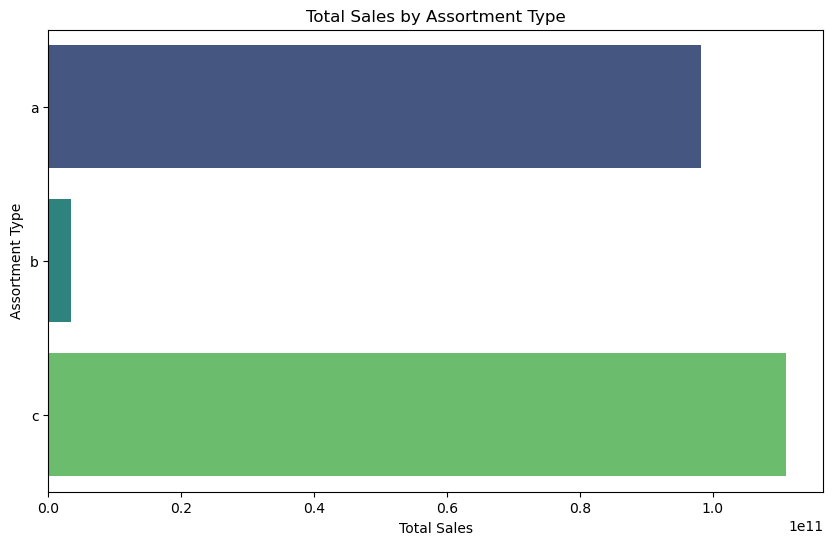

2024-09-20 19:18:44,106 - INFO - Total sales plot displayed successfully.
2024-09-20 19:18:44,107 - INFO - Creating bar plot for average sales by assortment type...
C:\Users\King Betse\AppData\Local\Temp\ipykernel_25272\2547502481.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sales', y='Assortment', data=average_sales_by_assortment, palette='viridis')


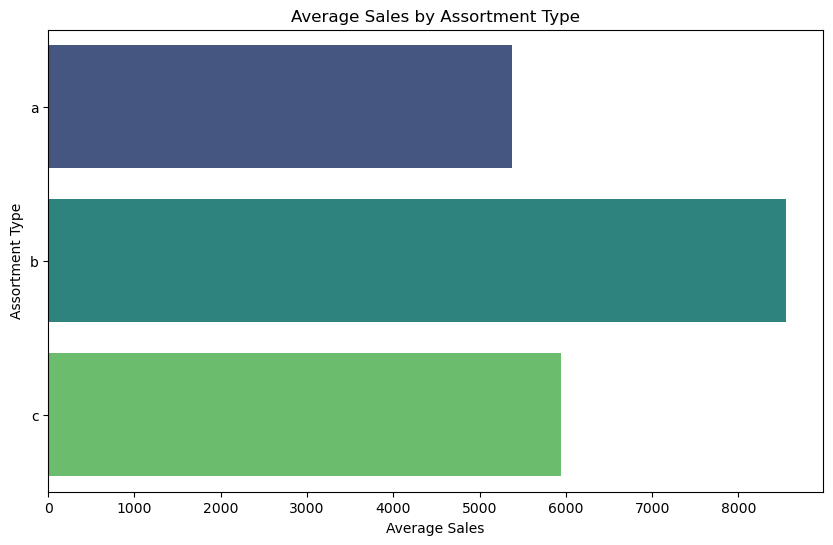

2024-09-20 19:18:44,322 - INFO - Average sales plot displayed successfully.


In [65]:
# Create a bar plot for total sales by assortment type
logger.info("Creating bar plot for total sales by assortment type...")
plt.figure(figsize=(10, 6))
sns.barplot(x='Sales', y='Assortment', data=sales_by_assortment, palette='viridis')
plt.title('Total Sales by Assortment Type')
plt.xlabel('Total Sales')
plt.ylabel('Assortment Type')
plt.show()
logger.info("Total sales plot displayed successfully.")

# Create a bar plot for average sales by assortment type
logger.info("Creating bar plot for average sales by assortment type...")
plt.figure(figsize=(10, 6))
sns.barplot(x='Sales', y='Assortment', data=average_sales_by_assortment, palette='viridis')
plt.title('Average Sales by Assortment Type')
plt.xlabel('Average Sales')
plt.ylabel('Assortment Type')
plt.show()
logger.info("Average sales plot displayed successfully.")

### Distance to Competitors and Sales

In [66]:
# Calculate correlation between Sales and Competition Distance
logger.info("Calculating correlation between Sales and Competition Distance...")
correlation = merged_data['Sales'].corr(merged_data['CompetitionDistance'])

# Log the correlation result
logger.info(f'Correlation between Sales and Competition Distance: {correlation}')

# Print the result
print(f'Correlation between Sales and Competition Distance: {correlation}')

2024-09-20 19:19:17,862 - INFO - Calculating correlation between Sales and Competition Distance...
2024-09-20 19:19:19,146 - INFO - Correlation between Sales and Competition Distance: 0.0014702674610508292


Correlation between Sales and Competition Distance: 0.0014702674610508292


### Visualization of Distance to Competitors and Sales

2024-09-20 19:19:40,226 - INFO - Creating scatter plot for Sales vs. Distance to Next Competitor...


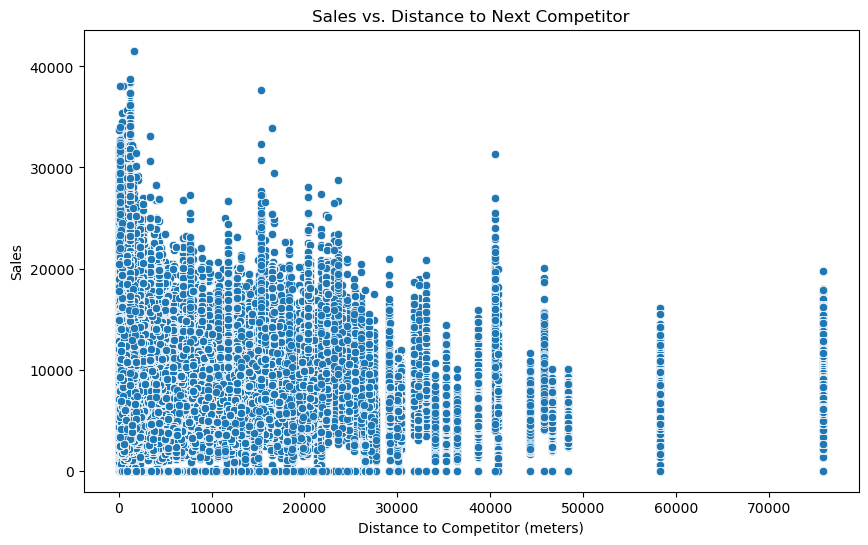

2024-09-20 19:21:27,246 - INFO - Scatter plot displayed successfully.


In [67]:
# Create a scatter plot for Sales vs. Distance to Next Competitor
logger.info("Creating scatter plot for Sales vs. Distance to Next Competitor...")
plt.figure(figsize=(10, 6))
sns.scatterplot(x='CompetitionDistance', y='Sales', data=merged_data)
plt.title('Sales vs. Distance to Next Competitor')
plt.xlabel('Distance to Competitor (meters)')
plt.ylabel('Sales')
plt.show()
logger.info("Scatter plot displayed successfully.")

### City Center Considerations

In [68]:
# Define threshold for city centers
city_center_threshold = 1000  # meters
logger.info(f"Identifying stores within {city_center_threshold} meters of city centers...")

# Filter stores within the city center threshold
city_center_stores = merged_data[merged_data['CompetitionDistance'] < city_center_threshold]

# Log the number of stores identified
logger.info(f"Number of stores within city center threshold: {city_center_stores.shape[0]}")

# Optionally, log a sample of the identified stores
logger.info(f"Sample of stores within city center threshold:\n{city_center_stores.head()}")

2024-09-20 19:21:27,261 - INFO - Identifying stores within 1000 meters of city centers...
2024-09-20 19:21:53,378 - INFO - Number of stores within city center threshold: 11272242
2024-09-20 19:21:53,451 - INFO - Sample of stores within city center threshold:
     Store  DayOfWeek_x      Date_x  Sales  Customers  Open_x  Promo_x  \
48       2            5  2015-07-31   6064        625       1        1   
97       4            5  2015-07-31  13995       1498       1        1   
99       6            5  2015-07-31   5651        589       1        1   
292     11            5  2015-07-31  10457       1236       1        1   
293     11            5  2015-07-31  10457       1236       1        1   

    StateHoliday_x  SchoolHoliday_x     Id  ...  SchoolHoliday_y StoreType  \
48               0                1    NaN  ...              NaN         a   
97               0                1    NaN  ...              NaN         c   
99               0                1    NaN  ...              N

### Comparing Sales in City Centers vs. Other Areas

In [69]:
# Calculate average sales in city centers
avg_sales_city_center = city_center_stores['Sales'].mean()
logger.info(f'Average Sales in City Centers: {avg_sales_city_center}')

# Calculate average sales in areas outside city centers
avg_sales_other = merged_data[merged_data['CompetitionDistance'] >= city_center_threshold]['Sales'].mean()
logger.info(f'Average Sales in Other Areas: {avg_sales_other}')

# Print the results
print(f'Average Sales in City Centers: {avg_sales_city_center}')
print(f'Average Sales in Other Areas: {avg_sales_other}')

2024-09-20 19:21:53,551 - INFO - Average Sales in City Centers: 5894.432216146531
2024-09-20 19:22:34,348 - INFO - Average Sales in Other Areas: 5613.4204371033975


Average Sales in City Centers: 5894.432216146531
Average Sales in Other Areas: 5613.4204371033975


### Identify Stores with NA Competitor Distance

In [70]:
# Identify stores with NA values for CompetitionDistance
logger.info("Identifying stores with NA values for CompetitionDistance...")
stores_with_na = merged_data[merged_data['CompetitionDistance'].isna()]

# Check unique stores with NA
unique_stores_with_na = stores_with_na['Store'].unique()
logger.info(f'Stores with NA Competition Distance: {unique_stores_with_na}')

# Print the unique stores with NA values
print(f'Stores with NA Competition Distance: {unique_stores_with_na}')

2024-09-20 19:22:34,430 - INFO - Identifying stores with NA values for CompetitionDistance...
2024-09-20 19:22:35,407 - INFO - Stores with NA Competition Distance: [291 622 879]


Stores with NA Competition Distance: [291 622 879]


###  Check for Updates in Competitor Distance

In [71]:
# Filter for stores that later received competition distance values
logger.info("Filtering for stores that had NA values for CompetitionDistance and later received valid values...")
updated_competitor_distance = merged_data[
    merged_data['Store'].isin(unique_stores_with_na) & 
    merged_data['CompetitionDistance'].notna()
]

# Log the result of the filtering
logger.info("Stores that had NA and later received competitor distance:")
logger.info(f"\n{updated_competitor_distance[['Store', 'CompetitionDistance', 'Date_y']].drop_duplicates()}")

# Print the result
print("Stores that had NA and later received competitor distance:")
print(updated_competitor_distance[['Store', 'CompetitionDistance', 'Date_y']].drop_duplicates())

2024-09-20 19:22:35,448 - INFO - Filtering for stores that had NA values for CompetitionDistance and later received valid values...
2024-09-20 19:22:36,099 - INFO - Stores that had NA and later received competitor distance:
2024-09-20 19:22:36,124 - INFO - 
Empty DataFrame
Columns: [Store, CompetitionDistance, Date_y]
Index: []


Stores that had NA and later received competitor distance:
Empty DataFrame
Columns: [Store, CompetitionDistance, Date_y]
Index: []
